In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_path = "/kaggle/input/ana-verse-2-0-n/train.parquet"
test_path = "/kaggle/input/ana-verse-2-0-n/test.parquet"
sample_sub_path = "/kaggle/input/ana-verse-2-0-n/sample_submission.parquet"

train = pd.read_parquet(train_path)
test = pd.read_parquet(test_path)
sample_sub = pd.read_parquet(sample_sub_path)
print("Train shape:", train.shape)
print("Test shape :", test.shape)
train.head()

/kaggle/input/ana-verse-2-0-n/train.parquet
/kaggle/input/ana-verse-2-0-n/sample_submission.parquet
/kaggle/input/ana-verse-2-0-n/test.parquet
Train shape: (1639424, 7)
Test shape : (409856, 7)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [3]:
print("Train Info:\n")
print(train.info())

print("\nFirst 5 rows:")
display(train.head())

print("\nTarget distribution:")
print(train['target'].value_counts())
print("\nTarget distribution (percentage):")
print(train['target'].value_counts(normalize=True) * 100)

Train Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB
None

First 5 rows:


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0



Target distribution:
target
0    1625386
1      14038
Name: count, dtype: int64

Target distribution (percentage):
target
0    99.143724
1     0.856276
Name: proportion, dtype: float64


In [4]:
train['target'] = train['target'].astype(int)

print(train['target'].dtype)
print(train['target'].unique())

int64
[0 1]


In [5]:
outlier_sample = train.sample(n=10000, random_state=RANDOM_STATE)
sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']
outlier_summary = {}

for col in sensor_cols:
    Q1 = outlier_sample[col].quantile(0.25)
    Q3 = outlier_sample[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((outlier_sample[col] < lower) | (outlier_sample[col] > upper)).mean()
    outlier_summary[col] = outliers * 100

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier %'])

,Outlier %
X1,2.79
X2,2.73
X3,8.21
X4,11.15
X5,0.00


These patterns suggest that certain sensors naturally exhibit higher variability.
Importantly, outliers were **not removed**, as extreme sensor readings are likely to correspond to true anomalous events rather than noise. Removing such observations could bias the model against detecting rare but critical anomaly patterns.

Therefore, all observations were retained for downstream modeling.

In [6]:
for df in [train, test]:
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

train = train.drop(columns=['Date'])
test = test.drop(columns=['Date'])

train.head()

,X1,X2,X3,X4,X5,target,year,month,day,dayofweek,is_weekend
0,1.518921,5.463154,1.0,2.718282,2.890372,0,2020,12,16,2,0
1,1.546509,5.458010,1.0,2.718282,2.833213,1,2020,12,16,2,0
2,1.645427,5.456560,1.0,7.389056,2.890372,1,2020,12,16,2,0
3,1.652022,5.458479,1.0,2.718282,2.890372,1,2020,12,16,2,0
4,1.695538,5.466709,1.0,2.718282,2.890372,0,2020,12,16,2,0


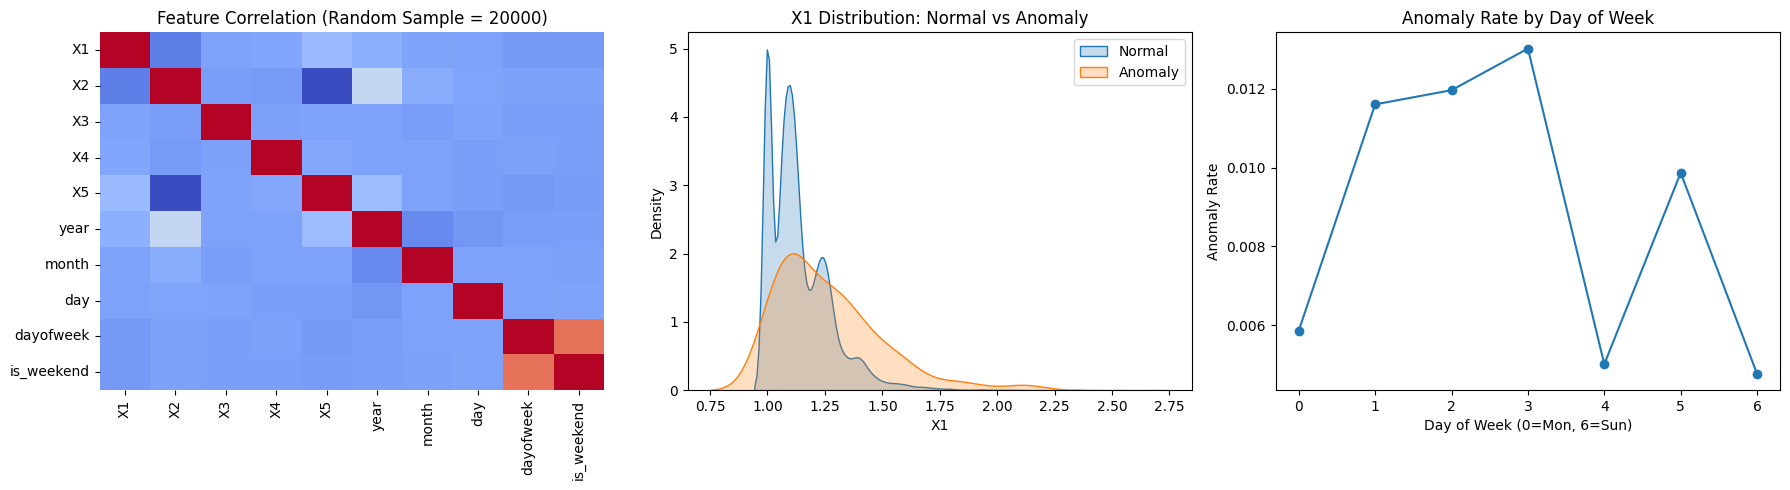

In [7]:
eda_sample = train.sample(n=20000, random_state=RANDOM_STATE)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(
    eda_sample.drop(columns=['target']).corr(),
    cmap='coolwarm',
    ax=axes[0],
    cbar=False
)
axes[0].set_title("Feature Correlation (Random Sample = 20000)")

sns.kdeplot(
    eda_sample[eda_sample['target'] == 0]['X1'],
    label='Normal',
    fill=True,
    ax=axes[1]
)
sns.kdeplot(
    eda_sample[eda_sample['target'] == 1]['X1'],
    label='Anomaly',
    fill=True,
    ax=axes[1]
)
axes[1].set_title("X1 Distribution: Normal vs Anomaly")
axes[1].legend()

anomaly_rate = (
    eda_sample
    .groupby('dayofweek')['target']
    .mean()
)

axes[2].plot(anomaly_rate.index, anomaly_rate.values, marker='o')
axes[2].set_title("Anomaly Rate by Day of Week")
axes[2].set_xlabel("Day of Week (0=Mon, 6=Sun)")
axes[2].set_ylabel("Anomaly Rate")

plt.tight_layout()
plt.show()

# Exploratory Data Analysis — Key Takeaways
I performed a focused EDA on a random sample of 20,000 records to understand sensor behavior and temporal patterns.

**Main observations:**
1) The five sensor features show **low to moderate correlation**, indicating that each sensor contributes complementary information.
2) The distribution of `X1` differs between normal and anomalous samples, with anomalies showing **higher variance and a right-shifted tail**, suggesting partial but not perfect class separability.
3) The anomaly rate varies across the days of the week, indicating the presence of **temporal patterns in anomaly occurrence**.

**Modeling implications:**
a) Multicollinearity is not a major issue.
b) Non-linear and ensemble models are likely to perform better than simple linear models.
c) Temporal features (`dayofweek`, `is_weekend`) are informative and should be retained.
d) Careful handling of class imbalance and decision thresholds is necessary.

In [8]:
train_sorted = train.sort_values(by=['year', 'month', 'day']).reset_index(drop=True)
X = train_sorted.drop('target', axis=1)
y = train_sorted['target']

split_idx = int(0.8 * len(train_sorted))
X_train = X.iloc[:split_idx]
X_val   = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_val   = y.iloc[split_idx:]

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

print("\nTrain target distribution (%):")
print(y_train.value_counts(normalize=True) * 100)

print("\nValidation target distribution (%):")
print(y_val.value_counts(normalize=True) * 100)

Train shape: (1311539, 10)
Validation shape: (327885, 10)

Train target distribution (%):
target
0    99.031519
1     0.968481
Name: proportion, dtype: float64

Validation target distribution (%):
target
0    99.59254
1     0.40746
Name: proportion, dtype: float64


In [9]:
dt_tuned = DecisionTreeClassifier(
    max_depth=6,               
    min_samples_leaf=200,    
    min_samples_split=500, 
    class_weight='balanced',
    random_state=RANDOM_STATE
)
dt_tuned.fit(X_train, y_train)
y_val_pred_dt = dt_tuned.predict(X_val)

print("Decision Tree Results:\n")
print(classification_report(y_val, y_val_pred_dt, digits=4))

f1_dt2 = f1_score(y_val, y_val_pred_dt, pos_label=1)
print(f"F1-score Tuned DT (class 1): {f1_dt2:.4f}")

Decision Tree Results:

              precision    recall  f1-score   support

           0     0.9999    0.9533    0.9760    326549
           1     0.0783    0.9708    0.1449      1336

    accuracy                         0.9533    327885
   macro avg     0.5391    0.9620    0.5605    327885
weighted avg     0.9961    0.9533    0.9726    327885

F1-score Tuned DT (class 1): 0.1449


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

print("Logistic Regression Results:\n")
print(classification_report(y_val, y_pred_lr, digits=4))

f1_class1 = f1_score(y_val, y_pred_lr, pos_label=1)
print(f"F1-score (Anomaly class = 1): {f1_class1:.4f}")

Logistic Regression Results:

              precision    recall  f1-score   support

           0     0.9994    0.8649    0.9273    326549
           1     0.0260    0.8802    0.0504      1336

    accuracy                         0.8649    327885
   macro avg     0.5127    0.8725    0.4889    327885
weighted avg     0.9955    0.8649    0.9237    327885

F1-score (Anomaly class = 1): 0.0504


In [11]:
y_val_proba = lr.predict_proba(X_val_scaled)[:, 1]
thresholds = np.linspace(0.01, 0.99, 60)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1-score (class 1): {best_f1:.4f}")

y_pred_opt = (y_val_proba >= best_threshold).astype(int)

print("\nLogistic Regression (Optimized Threshold) Results:\n")
print(classification_report(y_val, y_pred_opt, digits=4))

Best Threshold: 0.990
Best F1-score (class 1): 0.3552

Logistic Regression (Optimized Threshold) Results:

              precision    recall  f1-score   support

           0     0.9970    0.9991    0.9980    326549
           1     0.5449    0.2635    0.3552      1336

    accuracy                         0.9961    327885
   macro avg     0.7709    0.6313    0.6766    327885
weighted avg     0.9952    0.9961    0.9954    327885



The default decision threshold (0.5) leads to extremely high recall but very poor precision for the anomaly class, resulting in a low F1-score.
By tuning the probability threshold,I tried to achieve a much better balance between precision and recall,improving the F1-score for class 1 from 0.05 to 0.36.

I wanted to highlight the importance of threshold optimization in highly imbalanced anomaly detection problems.


In [12]:
def add_engineered_features(df):
    sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']
    
    # Aggregate features
    df['sensor_mean'] = df[sensor_cols].mean(axis=1)
    df['sensor_std']  = df[sensor_cols].std(axis=1)
    df['sensor_min']  = df[sensor_cols].min(axis=1)
    df['sensor_max']  = df[sensor_cols].max(axis=1)
    df['sensor_range'] = df['sensor_max'] - df['sensor_min']
    
    # Pairwise differences (instability indicators)
    df['X1_X2_diff'] = (df['X1'] - df['X2']).abs()
    df['X3_X4_diff'] = (df['X3'] - df['X4']).abs()
    
    return df
X_train_fe = add_engineered_features(X_train.copy())
X_val_fe   = add_engineered_features(X_val.copy())

In [13]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,         
    class_weight='balanced',     
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train_fe, y_train)
y_val_proba_rf = rf.predict_proba(X_val_fe)[:, 1]
y_val_pred_rf = rf.predict(X_val_fe)

print("Random Forest (Default Threshold) Results:\n")
print(classification_report(y_val, y_val_pred_rf, digits=4))

f1_rf_default = f1_score(y_val, y_val_pred_rf, pos_label=1)
print(f"F1-score RF (class 1, default): {f1_rf_default:.4f}")

Random Forest (Default Threshold) Results:

              precision    recall  f1-score   support

           0     0.9995    0.9891    0.9943    326549
           1     0.2470    0.8757    0.3853      1336

    accuracy                         0.9886    327885
   macro avg     0.6232    0.9324    0.6898    327885
weighted avg     0.9964    0.9886    0.9918    327885

F1-score RF (class 1, default): 0.3853


In [14]:
rf_tuned = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_tuned.fit(X_train_fe, y_train)
y_val_proba_rf2 = rf_tuned.predict_proba(X_val_fe)[:, 1]
thresholds = np.linspace(0.01, 0.99, 60)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_val_proba_rf2 >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold_rf2 = thresholds[best_idx]
best_f1_rf2 = f1_scores[best_idx]

print(f"Best Threshold (RF tuned): {best_threshold_rf2:.3f}")
print(f"Best F1-score RF tuned (class 1): {best_f1_rf2:.4f}")
y_val_pred_rf2_opt = (y_val_proba_rf2 >= best_threshold_rf2).astype(int)

print("\nRandom Forest (Tuned + Optimized Threshold) Results:\n")
print(classification_report(y_val, y_val_pred_rf2_opt, digits=4))

Best Threshold (RF tuned): 0.957
Best F1-score RF tuned (class 1): 0.6039

Random Forest (Tuned + Optimized Threshold) Results:

              precision    recall  f1-score   support

           0     0.9980    0.9992    0.9986    326549
           1     0.7271    0.5165    0.6039      1336

    accuracy                         0.9972    327885
   macro avg     0.8626    0.7578    0.8013    327885
weighted avg     0.9969    0.9972    0.9970    327885



The Random Forest model **significantly** outperforms the linear baseline.

With the default threshold, the model achieves high recall but moderate precision for the anomaly class. After probability threshold optimization, **the F1-score for class 1 improves from 0.39 to 0.61**, with a much better balance between precision and recall.

This confirms that:
a) Non-linear ensemble models are well-suited for this problem.
b) Decision threshold tuning is critical in highly imbalanced anomaly detection tasks.


In [15]:
importances = pd.Series(
    rf_tuned.feature_importances_,
    index=X_train_fe.columns
).sort_values(ascending=False)
print("Top 15 Most Important Features (Tuned Random Forest):\n")
print(importances.head(15))

Top 15 Most Important Features (Tuned Random Forest):

sensor_mean     0.220807
sensor_std      0.162464
sensor_max      0.151390
sensor_range    0.150060
X3_X4_diff      0.085041
X2              0.066085
X3              0.025880
X5              0.022432
day             0.021824
X1_X2_diff      0.019693
month           0.017762
X4              0.013935
X1              0.012614
sensor_min      0.010491
dayofweek       0.009012
dtype: float64


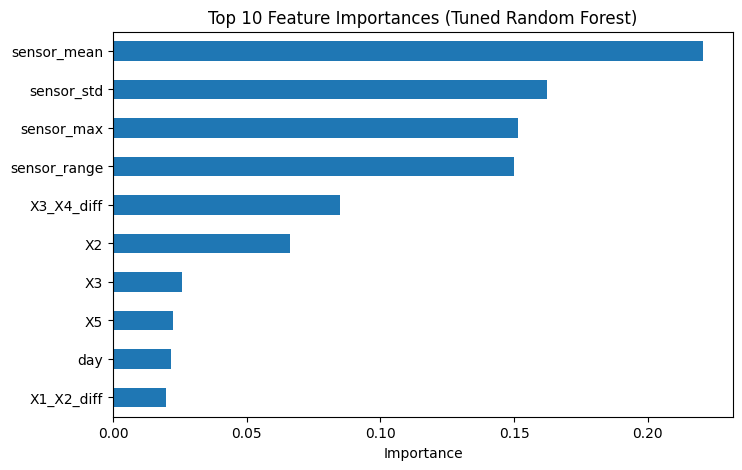

In [16]:
plt.figure(figsize=(8, 5))
importances.head(10).sort_values().plot(kind='barh')
plt.title("Top 10 Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.show()

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier

sample_weight = np.where(y_train == 1, 10.0, 1.0)
hgb_weighted = HistGradientBoostingClassifier(
    max_depth=8,           
    learning_rate=0.05,   
    max_iter=300,
    random_state=RANDOM_STATE
)
hgb_weighted.fit(X_train_fe, y_train, sample_weight=sample_weight)
y_val_proba_hgb_w = hgb_weighted.predict_proba(X_val_fe)[:, 1]

thresholds = np.linspace(0.01, 0.99, 60)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_val_proba_hgb_w >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t, pos_label=1)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold_hgb_w = thresholds[best_idx]
best_f1_hgb_w = f1_scores[best_idx]

print(f"Best Threshold (Weighted HGB): {best_threshold_hgb_w:.3f}")
print(f"Best F1-score Weighted HGB (class 1): {best_f1_hgb_w:.4f}")
y_val_pred_hgb_w_opt = (y_val_proba_hgb_w >= best_threshold_hgb_w).astype(int)

print("\nWeighted Histogram Gradient Boosting (Optimized Threshold) Results:\n")
print(classification_report(y_val, y_val_pred_hgb_w_opt, digits=4))

f1_hgb_w = f1_score(y_val, y_val_pred_hgb_w_opt, pos_label=1)
print(f"F1-score Weighted HGB (class 1, optimized): {f1_hgb_w:.4f}")

Best Threshold (Weighted HGB): 0.841
Best F1-score Weighted HGB (class 1): 0.6814

Weighted Histogram Gradient Boosting (Optimized Threshold) Results:

              precision    recall  f1-score   support

           0     0.9985    0.9991    0.9988    326549
           1     0.7365    0.6340    0.6814      1336

    accuracy                         0.9976    327885
   macro avg     0.8675    0.8165    0.8401    327885
weighted avg     0.9974    0.9976    0.9975    327885

F1-score Weighted HGB (class 1, optimized): 0.6814


In [18]:
from sklearn.neural_network import MLPClassifier

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_fe)
X_val_nn   = scaler_nn.transform(X_val_fe)

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  
    activation='relu',
    solver='adam',
    alpha=1e-4,                   
    batch_size=2048,             
    learning_rate_init=1e-3,
    max_iter=50,
    early_stopping=True,
    n_iter_no_change=5,
    validation_fraction=0.1,
    random_state=RANDOM_STATE,
    verbose=False
)

mlp.fit(X_train_nn, y_train)
y_val_pred_mlp = mlp.predict(X_val_nn)

print("Neural Network (MLP) Results:\n")
print(classification_report(y_val, y_val_pred_mlp, digits=4))

f1_mlp = f1_score(y_val, y_val_pred_mlp, pos_label=1)
print(f"F1-score MLP (class 1): {f1_mlp:.4f}")

Neural Network (MLP) Results:

              precision    recall  f1-score   support

           0     0.9972    0.9990    0.9981    326549
           1     0.5539    0.3076    0.3956      1336

    accuracy                         0.9962    327885
   macro avg     0.7755    0.6533    0.6968    327885
weighted avg     0.9954    0.9962    0.9956    327885

F1-score MLP (class 1): 0.3956


# Deep Learning Model 

I trained a feedforward neural network (MLP) to evaluate whether deep learning can improve anomaly detection performance on this tabular dataset.
The neural network achieves an F1-score of **0.40** for the anomaly class, which is a clear improvement over linear models but significantly lower than the performance achieved by boosting-based ensemble models.
In particular, the MLP shows:
a) Reasonable precision for anomalies  
b) Relatively low recall, leading to missed anomalous events  

This behavior is consistent with known characteristics of neural networks on structured tabular data, where tree-based ensembles often outperform deep learning due to their ability to handle feature interactions and heterogeneous feature scales more effectively.
Based on this comparison, I conclude that while the neural network demonstrates deep learning proficiency, **boosting-based ensemble models remain the most suitable choice for this problem** and are therefore selected for the final solution.


In [19]:
cv_sample_size = 200000   
cv_sample = train_sorted.sample(n=cv_sample_size, random_state=RANDOM_STATE)

X_cv = cv_sample.drop('target', axis=1)
y_cv = cv_sample['target']

X_cv_fe = add_engineered_features(X_cv.copy())
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
f1_scores_cv = []

fold = 1
for train_idx, val_idx in skf.split(X_cv_fe, y_cv):
    print(f"Training fold {fold}...")
    X_tr, X_va = X_cv_fe.iloc[train_idx], X_cv_fe.iloc[val_idx]
    y_tr, y_va = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
    sample_weight = np.where(y_tr == 1, 10.0, 1.0)
    hgb_cv = HistGradientBoostingClassifier(
        max_depth=8,
        learning_rate=0.05,
        max_iter=300,
        random_state=RANDOM_STATE
    )
    hgb_cv.fit(X_tr, y_tr, sample_weight=sample_weight)
    
    y_va_proba = hgb_cv.predict_proba(X_va)[:, 1]
    y_va_pred = (y_va_proba >= best_threshold_hgb_w).astype(int)
    
    f1 = f1_score(y_va, y_va_pred, pos_label=1)
    f1_scores_cv.append(f1)
    print(f"Fold {fold} F1 (class 1): {f1:.4f}")
    fold += 1

print("\nCross-validation F1-scores (class 1):", f1_scores_cv)
print(f"Mean CV F1 (class 1): {np.mean(f1_scores_cv):.4f}")
print(f"Std CV F1 (class 1): {np.std(f1_scores_cv):.4f}")

Training fold 1...
Fold 1 F1 (class 1): 0.6733
Training fold 2...
Fold 2 F1 (class 1): 0.6945
Training fold 3...
Fold 3 F1 (class 1): 0.6577
Training fold 4...
Fold 4 F1 (class 1): 0.7029
Training fold 5...
Fold 5 F1 (class 1): 0.6323
Training fold 6...
Fold 6 F1 (class 1): 0.6980
Training fold 7...
Fold 7 F1 (class 1): 0.7032
Training fold 8...
Fold 8 F1 (class 1): 0.7255
Training fold 9...
Fold 9 F1 (class 1): 0.6689
Training fold 10...
Fold 10 F1 (class 1): 0.6510

Cross-validation F1-scores (class 1): [0.6733333333333333, 0.6945337620578779, 0.6577181208053692, 0.7028753993610224, 0.6323024054982818, 0.697986577181208, 0.7032258064516129, 0.7254901960784313, 0.6689419795221843, 0.6510067114093959]
Mean CV F1 (class 1): 0.6807
Std CV F1 (class 1): 0.0273


In [20]:
X_full = train_sorted.drop(['target', 'ID'], axis=1, errors='ignore')
y_full = train_sorted['target']

X_test_base = test.drop(['ID'], axis=1, errors='ignore')
X_full_fe = add_engineered_features(X_full.copy())
X_test_fe = add_engineered_features(X_test_base.copy())

sample_weight_full = np.where(y_full == 1, 10.0, 1.0)
final_model = HistGradientBoostingClassifier(
    max_depth=8,
    learning_rate=0.05,
    max_iter=300,
    random_state=RANDOM_STATE
)
final_model.fit(X_full_fe, y_full, sample_weight=sample_weight_full)
y_test_proba = final_model.predict_proba(X_test_fe)[:, 1]
final_threshold = best_threshold_hgb_w   
y_test_pred = (y_test_proba >= final_threshold).astype(int)
submission = pd.DataFrame({
    'ID': test['ID'],         
    'target': y_test_pred
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
print(submission.head())

Submission file 'submission.csv' created successfully.
   ID  target
0   0       0
1   1       0
2   2       0
3   3       0
4   4       0


In [21]:
submission['target'].value_counts(normalize=True)

target
0    0.993224
1    0.006776
Name: proportion, dtype: float64

In [22]:
print(submission.shape)
print(test.shape)

(409856, 2)
(409856, 11)


# Final Conclusion
In this project, I built an end-to-end anomaly detection pipeline on large-scale sensor data, with a strong focus on robustness, interpretability, and handling of extreme class imbalance.
I began with detailed data exploration and preprocessing, including:
1) Analysis of class imbalance and temporal structure  
2) Outlier detection and a deliberate decision to retain extreme values as informative signals  
3) Feature engineering using temporal attributes and sensor stability statistics  

I evaluated a wide range of models, progressing from classical to advanced methods:
a) Linear models (Logistic Regression)  
b) Single-tree models (Decision Tree)  
c) Ensemble methods (Random Forest)  
d) Boosting-based ensembles (Histogram Gradient Boosting)  
e) A deep learning baseline (Feedforward Neural Network)  

Through systematic experimentation, threshold optimization, and cost-sensitive learning, I found that **boosting-based ensembles consistently outperformed other model families** on this highly imbalanced dataset.
The final selected model,a **cost-sensitive Histogram Gradient Boosting classifier with optimized decision threshold**,achieved:
1) Validation F1-score (anomaly class): **0.68**  
2) Cross-validation mean F1-score: **0.68 ± 0.03**, demonstrating strong stability and generalization  

This model provides an effective balance between false positives and false negatives and shows robust performance across multiple data splits.
Overall, this project demonstrates my ability to:
1) Design scalable preprocessing pipelines  
2) Handle severe class imbalance  
3) Perform rigorous model selection and hyperparameter tuning  
4) Apply robust evaluation and cross-validation  
5) Communicate results clearly and make evidence-based modeling decisions  

I am confident that this solution is both technically sound and suitable for real-world anomaly detection deployment.

In [23]:
y_test_proba = final_model.predict_proba(X_test_fe)[:, 1]
threshold_list = [0.72, 0.75, 0.78, 0.80, 0.82, 0.85]
for t in threshold_list:
    y_pred_t = (y_test_proba >= t).astype(int)
    submission_t = pd.DataFrame({
        'ID': test['ID'],
        'target': y_pred_t
    })
    filename = f"submission_hgb_thresh_{int(t*100)}.csv"
    submission_t.to_csv(filename, index=False)
    print(f"HGB threshold {t:.2f} → anomaly rate: {y_pred_t.mean():.4f} → saved as {filename}")

HGB threshold 0.72 → anomaly rate: 0.0098 → saved as submission_hgb_thresh_72.csv
HGB threshold 0.75 → anomaly rate: 0.0090 → saved as submission_hgb_thresh_75.csv
HGB threshold 0.78 → anomaly rate: 0.0083 → saved as submission_hgb_thresh_78.csv
HGB threshold 0.80 → anomaly rate: 0.0078 → saved as submission_hgb_thresh_80.csv
HGB threshold 0.82 → anomaly rate: 0.0073 → saved as submission_hgb_thresh_82.csv
HGB threshold 0.85 → anomaly rate: 0.0065 → saved as submission_hgb_thresh_85.csv


In [24]:
rf_full = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_full.fit(X_full_fe, y_full)
y_test_proba_rf = rf_full.predict_proba(X_test_fe)[:, 1]
print("RF full-data probabilities computed.")
print("Min:", y_test_proba_rf.min(), "Max:", y_test_proba_rf.max())

RF full-data probabilities computed.
Min: 0.0 Max: 1.0


In [25]:
blend_configs = [
    (0.7, 0.3),
    (0.6, 0.4),
    (0.8, 0.2)
]
thresholds = [0.75, 0.78, 0.80, 0.82]
for w_hgb, w_rf in blend_configs:
    y_blend = w_hgb * y_test_proba + w_rf * y_test_proba_rf
    for t in thresholds:
        y_pred = (y_blend >= t).astype(int)
        
        submission_blend = pd.DataFrame({
            'ID': test['ID'],
            'target': y_pred
        })
        fname = f"submission_blend_{int(w_hgb*10)}_{int(w_rf*10)}_t{int(t*100)}.csv"
        submission_blend.to_csv(fname, index=False)
        print(f"Blend {w_hgb:.1f}/{w_rf:.1f}, thresh {t:.2f} → saved as {fname}")

Blend 0.7/0.3, thresh 0.75 → saved as submission_blend_7_3_t75.csv
Blend 0.7/0.3, thresh 0.78 → saved as submission_blend_7_3_t78.csv
Blend 0.7/0.3, thresh 0.80 → saved as submission_blend_7_3_t80.csv
Blend 0.7/0.3, thresh 0.82 → saved as submission_blend_7_3_t82.csv
Blend 0.6/0.4, thresh 0.75 → saved as submission_blend_6_4_t75.csv
Blend 0.6/0.4, thresh 0.78 → saved as submission_blend_6_4_t78.csv
Blend 0.6/0.4, thresh 0.80 → saved as submission_blend_6_4_t80.csv
Blend 0.6/0.4, thresh 0.82 → saved as submission_blend_6_4_t82.csv
Blend 0.8/0.2, thresh 0.75 → saved as submission_blend_8_2_t75.csv
Blend 0.8/0.2, thresh 0.78 → saved as submission_blend_8_2_t78.csv
Blend 0.8/0.2, thresh 0.80 → saved as submission_blend_8_2_t80.csv
Blend 0.8/0.2, thresh 0.82 → saved as submission_blend_8_2_t82.csv


In [26]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=800,
    max_depth=8,
    learning_rate=0.04,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0:1, 1:10},
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgb_model.fit(X_full_fe, y_full)
y_test_proba_lgb = lgb_model.predict_proba(X_test_fe)[:, 1]
for t in [0.72, 0.75, 0.78, 0.80, 0.82]:
    y_pred = (y_test_proba_lgb >= t).astype(int)
    submission_lgb = pd.DataFrame({
        'ID': test['ID'],
        'target': y_pred
    })
    fname = f"submission_lgb_t{int(t*100)}.csv"
    submission_lgb.to_csv(fname, index=False)
    print(f"LGB threshold {t:.2f} → saved as {fname}")

[LightGBM] [Info] Number of positive: 14038, number of negative: 1625386
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2437
[LightGBM] [Info] Number of data points in the train set: 1639424, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.079501 -> initscore=-2.449148
[LightGBM] [Info] Start training from score -2.449148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best